In [28]:
import json
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

In [19]:
stop_words = stopwords.words('german')

In [21]:
years = ['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'] # Hier die Jahre angeben, die geladen werden sollen (final: 2016-2023)
path = "/Users/jan/Documents/Promotion/BIBB GW/hdd/Pflege/"#Hier der Pfad zu den JSON-Dateien!
with open(f"{path}Pflege_2016.json", 'r') as file: # 2016 ersetzen: durch years iterieren - zu viele Daten, wenn alle Jahre geladen werden?
    output = json.load(file)
readpro = [[value] for value in output["full_text"].values()]
del output

In [23]:
def tokenize(text):
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Split into words
    tokens = text.split()
    return tokens
prepro = []
for value in readpro:
    add = tokenize(value[0])
    prepro.append(add)
# Build the bigram and trigram models
bigram = gensim.models.Phrases(prepro, min_count=2, threshold=5) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[prepro], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[prepro[0]]])

['altenpflegeraltenpflegerin_arbeitsort_d', 'berlin_berlin', 'firmenname_perzukunft', 'arbeitsvermittlung_gmbh_co', 'kg', 'alter', 'der', 'anzeige_tage_alt', 'stellenbeschreibung_stellenbezeichnung', 'altenpflegeraltenpflegerin_jobbeschreibung', 'wir', 'suchen', 'engagierte', 'altenpfleger_mw', 'fr', 'ein', 'berliner_seniorenheim', 'bewerben', 'sie', 'sich', 'noch_heute', 'auf', 'eine', 'unbefristete_vollzeitstelle', 'was', 'sie', 'erwarten', 'wird', 'fachgerechte', 'betreuung', 'der', 'senioren', 'grundpflege', 'behandlungspflege', 'medikamente', 'und', 'spritzen', 'verabreichen', 'anleiten', 'der', 'pflegehilfskrfte', 'ttigkeiten', 'abgeschlossene_ausbildung', 'zum', 'altenpfleger_mw', 'fundierte_kenntnisse', 'in', 'der', 'pharmakologie', 'einfhlungsvermgen', 'wir', 'freuen', 'uns', 'auf', 'sie', 'bewerben', 'sie', 'sich', 'am_besten', 'noch_heute', 'telefonisch', 'unter_bitte_beachten', 'sie', 'dass', 'die', 'bewerbungsunterlagen', 'nur_zurck_gesandt', 'werden', 'wenn', 'ein', 'ents

In [24]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [25]:
# Remove Stop Words
data_words_nostops = remove_stopwords(prepro)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy model, keeping only tagger component (for efficiency)
nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['Arbeitsort', 'firmenname_perzukunft', 'alt', 'anzeige_tage', 'alt', 'Jobbeschreibung', 'suchen', 'engagieren', 'altenpfleger_mw', 'bewerben', 'heute', 'unbefristete_vollzeitstell', 'erwarten', 'fachgerecht', 'Betreuung', 'senioren', 'Grundpflege', 'medikament', 'Spritze', 'anleit', 'ttigkeit', 'Abgeschlossene_ausbildung', 'altenpfleger_mw', 'fundierte_kenntnisse', 'Pharmakologie', 'freuen', 'bewerben', 'heute', 'telefonisch', 'zurck_gesandt', 'entsprechend_ausreichend', 'Frankierter_rckumschlag', 'Beigefgt', 'bitte', 'fall', 'fahrtkosten', 'Bernomm', 'bitte_beachten', 'Folgenden_anforderunge', 'kompetenzen', 'erwachsen', 'grundkenntnisse_grundkenntnisse', 'soziale_kompetenzen', 'flexibilitaet', 'kontaktadresse_lautet', 'Perzukunft', 'frau_michell', 'kosmonaut', 'Telefonnummer_faxnummer', 'Arbeitsort', 'Anstellung', 'Arbeitsplatz', 'Vollzeit', 'Kontakt', 'Frau', 'kosmonaut', 'emailadresse', 'webseit', 'gewnscht', 'Form', 'telefonisch', 'schriftlich', 'persnlich', 'Internet', 'geforde

In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 2), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1)]]


In [27]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0,
  '0.020*"Stellenangebot" + 0.017*"Arbeitgeber" + 0.016*"finden" + '
  '0.013*"Altenpflegerin" + 0.010*"Besetzung" + 0.010*"suchen" + '
  '0.009*"Vergtung" + 0.009*"Arbeitsplatz" + 0.009*"kondition" + '
  '0.009*"Beginn"'),
 (1,
  '0.012*"gesundheits" + 0.012*"suchen" + 0.009*"mw" + 0.009*"krankenpfleg" + '
  '0.008*"bieten" + 0.007*"Altenpflegerin" + 0.007*"bewerben" + 0.007*"Pflege" '
  '+ 0.007*"Gmbh" + 0.007*"Aufgabe"'),
 (2,
  '0.013*"Arbeitgeber" + 0.013*"Angebot" + 0.012*"erhalten" + '
  '0.009*"Altenpflegerin" + 0.009*"Stellenangebot" + 0.009*"suchen" + '
  '0.008*"gesundheits" + 0.007*"zwingend" + 0.007*"Kosten" + '
  '0.007*"Adresszeil"')]

Perplexity:  -8.049590918832406

Coherence Score:  -0.9100124914754236


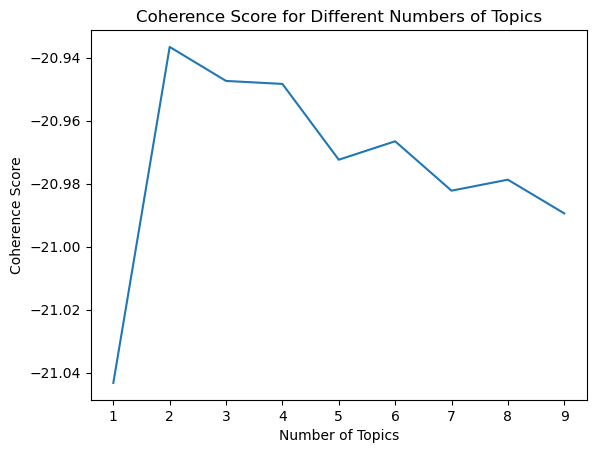

Optimal number of topics: 2


In [16]:
coherence_scores = []
topic_range = range(1, 10)  # test for topic numbers from 2 to 20

for num_topics in topic_range:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

# Step 4: Plot the coherence scores
plt.plot(topic_range, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score for Different Numbers of Topics')
plt.show()

# Step 5: Find the optimal number of topics
optimal_topics = topic_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal number of topics: {optimal_topics}")